In [1]:
import numpy as np
from sympy import *
from sympy.solvers import solve
init_printing(use_unicode=True)

## Functions


In [2]:
def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

### Solve the Lyapunov equation for $\Sigma$

In [3]:
def solve_lyapunov_cov(M: Matrix, C: Matrix, p: int) -> Matrix:
    Sigma = MatrixSymbol("Sigma", p, p).as_explicit()
    Sigma_solved = solve(M*Sigma + Sigma*M.T + C, Sigma)
    scheme = [[Sigma_solved[Sigma[i,j]] for i in range(p)] for j in range(p)]
    Sigma_new = Matrix(scheme)
    return Sigma_new

### Create $A(\Sigma)$

The column indices $i \to j$ are translated to single numbers by $p*i + j$ with $p= |V|$. The row indices $(k,l)$ with $k\leq l$ are translated to single numbers by $k * p + \left( l - \frac{k(k+1)}{2}\right).$

In [4]:
def create_A_Sigma(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

Add the identity matrices multiplied by the mean.

In [5]:
def create_A(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

Add the unit vector multiplied by the negative scalar of the shift intervention to $vech(C)$.

In [6]:
def create_c(vech_C: Matrix, b: float, index: int, p: int) -> Matrix:
    unit_vector = eye(p).col(index)
    return Matrix. vstack(vech_C, - b * unit_vector)

## General settings
General variables

In [7]:
# Number of nodes p=|V|
p = 3

In [8]:
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])

m11 = symbols('m11')
m12 = symbols('m12')
m13 = symbols('m13')
m14 = symbols('m14')
m21 = symbols('m21')
m22 = symbols('m22')
m23 = symbols('m23')
m24 = symbols('m24')
m31 = symbols('m31')
m32 = symbols('m32')
m33 = symbols('m33')
m34 = symbols('m34')
m41 = symbols('m41')
m42 = symbols('m42')
m43 = symbols('m43')
m44 = symbols('m44')

M_2 = Matrix([[m11, m12], [m21, m22]])
M_3 = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])
M_4 = Matrix([[m11, m12, m13, m14], [m21, m22, m23, m24], [m31, m32, m33, m34], [m41, m42, m43, m44]])

mean_2 = Matrix([[2], [1]])
mean_3 = Matrix([[2], [1], [4]])
mean_4 = Matrix([[1], [3], [6], [2]])


Fixed values

In [9]:
# Volatility matrix C
C = 2 * eye(p)

# Index of shift intervention
index = 0
# Parameter of shift intervention
b = 2
# Corresponding unit vector
unit_v = eye(p).col(index)

# Probability of edges in graph
k = 2
d = min(k / p + 0.1, 1)

Dependent on $p$

In [10]:
# ----------------------------------------------
# TODO: change this for p
# ----------------------------------------------
M = M_3
mean = mean_3

## Approach with $A(\Sigma)$
### From $M$, $C$, $b$, $i$, $p$ construct $\Sigma$, $\mu$
First, let us generate a random stable matrix $M$.

In [11]:
np.random.seed(1208)

# Bernoulli distribution with prob p=d,
# determines which entries are 0 (no edge)
bernoulli_matrix = np.random.binomial(1, d, (p, p))
# Standard Gaussian distribution N(0,1)
normal_matrix = np.random.normal(0, 1, (p, p))

temp_M = bernoulli_matrix * normal_matrix
# Adjust diagonal entries s.t. M stable
for i in range(p):
    row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
    temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

concrete_M = Matrix(temp_M)

Now, we find the corresponding covariance matrix $\Sigma$ by solving the Lyapunov equation with $M$ and $C$ for $\Sigma$ and the mean corresponding to a shift intervention on node $i$ with scalar $b$ by setting
$$\mu = b \cdot M^{-1} e_i.$$

In [12]:
cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
mean = b * concrete_M.inv() * unit_v

### Estimate $M$ from $\Sigma$, $C$, $\mu$, $b$, $i$, $p$

In [13]:
vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)


c = create_c(vech_C=vech_C, b=b, index=index, p=p)

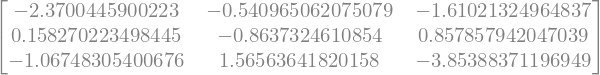

In [14]:
M_est = M.subs(solve(A * vec_M + c, vec_M))
M_est

### Evaluate estimation

In [19]:
matrix2numpy(concrete_M)
# frob = np.linalg.norm(matrix2numpy(M_est) - matrix2numpy(concrete_M))
# frob

array([[-2.30386206293535, -0.653729606151196, -1.36415817641326],
       [0.0, -0.655034842767227, 0.297089609083519],
       [-1.13142101287898, 1.75653041611095, -4.12876385737464]],
      dtype=object)

## Possible graphs to consider

### 2 nodes with a 2-cycle
<div>
<img src="graph1.png" width="400"/>
</div>

### 3 nodes with a 2-cycle and a 3-cycle
<div>
<img src="graph2.png" width="400"/>
</div>

In [ ]:
substitute = {m12: 0, m31: 0}
# M.subs(substitute)

### 3 nodes with a 2-cycle and connected by treks
<div>
<img src="graph3.png" width="400"/>
</div>

In [ ]:
substitute = {m12: 0, m13: 0}

### 3 nodes with a 2-cycle and not connected by treks
<div>
<img src="graph4.png" width="400"/>
</div>

In [ ]:
substitute = {m12: 0, m13: 0, m31: 0}

## Failed Approach: $M\Sigma + \Sigma M^\top + C = 0$
We tried to first adjust the matrix $M$ for the shift intervention and then solve the Lyapunov equation. This did not work since the adjustment was not thought correctly. We cannot set certain values of $M^{-1}$ to the corresponding values, this takes away information. We need to treat these equations as extra information that needs to go alongside the Lyapunov equation.


The functions used for this approach are the following:


### Adjust $M$ after shift intervention

Since we define the shift intervention on a node $i$ of the process $X(t)$ with mean zero to be described as
$$dX^I(t) = (MX^I(t)-b_ie_i)dt+DdW(t) = M(X^I(t)-M^{-1}b_ie_i)dt+DdW(t)$$
the new mean after the intervention has changed to be $\mathbb{E}(X^I(t)) = M^{-1}b_ie_i$. Therefore, if we know the empirical mean of the process $X^I(t)$ after the shift intervention, we also know the $i$-th column of the inverse of the drift matrix $M$
$$(M^{-1})_{\cdot i} = M^{-1}e_i = \frac{1}{b_i}\mathbb{E}(X^I(t)).$$

In [ ]:
'''def adjust_M(M: Matrix, col: int, b: float, emp_mean: Matrix, p: int) -> Matrix:
    M_inv = M.inv()
    for row in range(p):
        M_inv[row, col] = (1 / b) * emp_mean[row]
    return M_inv.inv()'''

### Solve Lyapunov equation for $M$

In [ ]:
def solve_lyapunov_M(Sigma: Matrix, C: Matrix, p: int) -> Matrix:
    M = MatrixSymbol("M", p, p).as_explicit()
    M_solved = solve(M * Sigma + Sigma * M.T + C, M)
    return M_solved

Now let's accomodate shift interventions by first adjusting $M$ as seen below and then solving the Lyapunov equation.

***Doubts:*** In which order do we set the constraints for M: first inverse then Lyapunov equation or the other way around? maybe it's better to work with $A(\Sigma)$ and optimize directly?

In [ ]:
'''def solve_lyapunov_M_interv(M: Matrix, Sigma: Matrix, C: Matrix, p: int, A: list[int], b: list[float], emp_mean: list[Matrix]) -> Matrix:
    for index, col in enumerate(A):
        M = adjust_M(M=M, col=col, b=b[index], emp_mean=emp_mean[index], p=p)
    M_solved = solve(M * Sigma + Sigma * M.T + C, M)
    return M_solved'''

### 2 nodes with a 2-cycle
<div>
<img src="graph1.png" width="400"/>
</div>

Let's start by defining the drift matrix $M$ corresponding to the graph $G=(V,E)$ with nodes $V=\{1,2\}$ and edges $E=\{1\to 1, 1\to 2, 2\to 1, 2\to 2\}$.

In [ ]:
p = 2

C = 2 * eye(p)
cov = MatrixSymbol("Sigma", p, p).as_explicit()

m11 = symbols('m11')
m12 = symbols('m12')
m21 = symbols('m21')
m22 = symbols('m22')

b_1 = 2
b_2 = 2

emp_mean_1 = Matrix([[1], [1]])
emp_mean_2 = Matrix([[1], [2]])

M = Matrix([[m11, m12], [m21, m22]])

In [ ]:
# Intervention on 1
A = [0]
b = [b_1]
emp_mean = [emp_mean_1]

M_est = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p, A=A, b=b, emp_mean=emp_mean)
M_est

In [ ]:
# Intervention on 2
A = [1]
b = [b_2]
emp_mean = [emp_mean_2]

M_est = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p, A=A, b=b, emp_mean=emp_mean)
M_est

### 3 nodes with a 2-cycle and a 3-cycle
<div>
<img src="graph2.png" width="400"/>
</div>

Let's start by defining the drift matrix $M$ corresponding to the graph $G=(V,E)$ with nodes $V=\{1,2,3\}$ and edges $E=\{1\to 1, 1\to 2, 2\to 2, 2\to 3, 3\to 1, 3\to 2, 3\to 3\}$.

In [ ]:
# Eigenvalues are {-2.837, -2.151, -1.012} -> stable!

substitute_zero = {m12: 0, m31: 0}
M = M.subs(substitute_zero)

# Find corresponding mean vectors
emp_mean_1 = b_1 * (M.inv()).col(0)
emp_mean_2 = b_2 * (M.inv()).col(1)
emp_mean_3 = b_3 * (M.inv()).col(2)

# Find corresponding covariance matrix
cov = solve_lyapunov_cov(M=M, C=C, p=p)

In [ ]:
# Intervention auf 1
A = [0]
b = [b_1]
emp_mean = [emp_mean_1]
M_est_1 = solve_lyapunov_M_interv(M=M_general, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_1

# General case: not terminated after 5 min
# Concrete numbers: not terminated after 5 min

In [ ]:
# Intervention auf 2
A = [1]
b = [b_2]
emp_mean = [emp_mean_2]
M_est_2 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_2

# General case: not terminated after 5 min
# Concrete numbers: not terminated after 3 min

In [ ]:
# Intervention auf 3
A = [2]
b = [b_3]
emp_mean = [emp_mean_3]
M_est_3 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_3

# General case: not terminated after 5 min
# Concrete numbers: not terminated after 2 min

In [ ]:
# Intervention auf 1 und 2
A = [0, 1]
b = [b_1, b_2]
emp_mean = [emp_mean_1, emp_mean_2]
M_est_12 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_12

In [ ]:
# Intervention auf 1 und 3
A = [0, 2]
b = [b_1, b_3]
emp_mean = [emp_mean_1, emp_mean_3]
M_est_13 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_13

In [ ]:
# Intervention auf 2 und 3
A = [1, 2]
b = [b_2, b_3]
emp_mean = [emp_mean_2, emp_mean_3]
M_est_23 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_23

### 3 nodes with a 2-cycle and connected by treks
<div>
<img src="graph3.png" width="400"/>
</div>

Let's start by defining the drift matrix $M$ corresponding to the graph $G=(V,E)$ with nodes $V=\{1,2,3\}$ and edges $E=\{1\to 1, 1\to 2, 1\to 3, 2\to 2, 2\to 3, 3\to 2, 3\to 3\}$.

In [ ]:
# Eigenvalues are {-2.687, -2.206, -1.108} -> stable!

substitute_zero = {m12: 0, m13: 0}
M = M.subs(substitute_zero)

# Find corresponding mean vectors
emp_mean_1 = b_1 * (M.inv()).col(0)
emp_mean_2 = b_2 * (M.inv()).col(1)
emp_mean_3 = b_3 * (M.inv()).col(2)

# Find corresponding covariance matrix
cov = solve_lyapunov_cov(M=M, C=C, p=p)

In [ ]:
# Intervention auf 1
A = [0]
b = [b_1]
emp_mean = [emp_mean_1]
M_est_1 = solve_lyapunov_M_interv(M=M_general, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_1

In [ ]:
# Intervention auf 2
A = [1]
b = [b_2]
emp_mean = [emp_mean_2]
M_est_2 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_2

In [ ]:
# Intervention auf 3
A = [2]
b = [b_3]
emp_mean = [emp_mean_3]
M_est_3 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_3

In [ ]:
# Intervention auf 1 und 2
A = [0, 1]
b = [b_1, b_2]
emp_mean = [emp_mean_1, emp_mean_2]
M_est_12 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_12

In [ ]:
# Intervention auf 1 und 3
A = [0, 2]
b = [b_1, b_3]
emp_mean = [emp_mean_1, emp_mean_3]
M_est_13 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_13

In [ ]:
# Intervention auf 2 und 3
A = [1, 2]
b = [b_2, b_3]
emp_mean = [emp_mean_2, emp_mean_3]
M_est_23 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_23

Kovarianzmatrix berechnen:
* Ohne Intervention klappt nicht (Laufzeit >1 min und kein Ergebnis).
* Intervention auf 1 klappt.
* Intervention auf 2 klappt nicht (Laufzeit >1 min und kein Ergebnis).
* Intervention auf 3 klappt nicht (Laufzeit >1 min und kein Ergebnis).
* Intervention auf 1 und 2 klappt.
* Intervention auf 1 und 3 klappt.
* Intervention auf 2 und 3 klappt nicht (Laufzeit >1 min und kein Ergebnis).
* Intervention auf 1, 2 und 3 klappt ($M$ eindeutig bestimmt).

### 3 nodes with a 2-cycle and not connected by treks
<div>
<img src="graph4.png" width="400"/>
</div>

Let's start by defining the drift matrix $M$ corresponding to the graph $G=(V,E)$ with nodes $V=\{1,2,3\}$ and edges $E=\{1\to 1, 1\to 2, 2\to 2, 2\to 3, 3\to 2, 3\to 3\}$.

In [ ]:
# Eigenvalues are {-2.687, -2.206, -1.108} -> stable!

substitute_zero = {m12: 0, m13: 0, m31: 0}
M = M.subs(substitute_zero)

# Find corresponding mean vectors
emp_mean_1 = b_1 * (M.inv()).col(0)
emp_mean_2 = b_2 * (M.inv()).col(1)
emp_mean_3 = b_3 * (M.inv()).col(2)

# Find corresponding covariance matrix
cov = solve_lyapunov_cov(M=M, C=C, p=p)

In [ ]:
# Intervention auf 1
A = [0]
b = [b_1]
emp_mean = [emp_mean_1]
M_est_1 = solve_lyapunov_M_interv(M=M_general, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_1

In [ ]:
# Intervention auf 2
A = [1]
b = [b_2]
emp_mean = [emp_mean_2]
M_est_2 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_2

In [ ]:
# Intervention auf 3
A = [2]
b = [b_3]
emp_mean = [emp_mean_3]
M_est_3 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_3

In [ ]:
# Intervention auf 1 und 2
A = [0, 1]
b = [b_1, b_2]
emp_mean = [emp_mean_1, emp_mean_2]
M_est_12 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_12

In [ ]:
# Intervention auf 1 und 3
A = [0, 2]
b = [b_1, b_3]
emp_mean = [emp_mean_1, emp_mean_3]
M_est_13 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_13

In [ ]:
# Intervention auf 2 und 3
A = [1, 2]
b = [b_2, b_3]
emp_mean = [emp_mean_2, emp_mean_3]
M_est_23 = solve_lyapunov_M_interv(M=M, Sigma=cov, C=C, p=p , A=A, b=b, emp_mean=emp_mean)
M_est_23

Kovarianzmatrix berechnen:
* Ohne Intervention klappt.
* Intervention auf 1 klappt.
* Intervention auf 2 klappt nicht (Laufzeit >1 min und kein Ergebnis).
* Intervention auf 3 klappt.
* Intervention auf 1 und 2 klappt.
* Intervention auf 1 und 3 klappt.
* Intervention auf 2 und 3 klappt nicht (Laufzeit >1 min und kein Ergebnis).
* Intervention auf 1, 2 und 3 klappt ($M$ eindeutig bestimmt).